In [ ]:
!pip install comet_ml
!pip install datasets
!pip install torchinfo
!pip install torchmetrics

In [ ]:
import comet_ml

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import DataLoader

import einops
import numpy as np

import matplotlib
from matplotlib import pyplot as plt

from datasets import load_dataset, DatasetDict

from torch.utils.data import DataLoader  # NOQA
import torchvision.transforms as T
from datasets import load_dataset  # NOQA

from torchinfo import summary  # NOQA

from tqdm import tqdm  # NOQA

from comet_ml.integration.pytorch import log_model  # NOQA

from torchmetrics.functional.image import structural_similarity_index_measure  # NOQA

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [ ]:
# PARAMETERS TO SET
BATCH_SIZE = 16
MAX_EPOCH = 10
WORKERS = 2
PIN_MEMORY = True
LR = 3e-4

def setup_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        # Set default tensor type for cuda
        torch.set_default_dtype(torch.float32)
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
        # Ensure we're using float32 on CPU
        torch.set_default_dtype(torch.float64)
    return device

device = setup_device()

print(f"Using {device} device")

ds = load_dataset("Artificio/WikiArt_Full").with_format("torch")

# 90% train, 10% test + validation
train_testvalid = ds['train'].train_test_split(test_size=0.2)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
train_test_valid_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']}).with_format("torch")

ds = train_test_valid_dataset
print(ds)

train_loader = DataLoader(
    ds["train"],
    batch_size=BATCH_SIZE,
    num_workers=WORKERS,
    shuffle=False,
    pin_memory=PIN_MEMORY,
)

test_loader = DataLoader(
    ds["test"],
    batch_size=BATCH_SIZE,
    num_workers=WORKERS,
    shuffle=False,
    pin_memory=PIN_MEMORY,
)

val_loader = DataLoader(
    ds["valid"],
    batch_size=BATCH_SIZE,
    num_workers=WORKERS,
    shuffle=False,
    pin_memory=PIN_MEMORY,
)

dataloaders = [
    train_loader,
    test_loader,
    val_loader,
]

for split in ds.keys():  # Iterate over 'train', 'test', 'valid'
    print(f"Split: {split}")
    for column, dtype in ds[split].features.items():
        print(f"Column: {column}, Type: {dtype}")
    print("-" * 40)


Using cuda device
DatasetDict({
    train: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'resnet50_non_robust_feats', 'resnet50_robust_feats'],
        num_rows: 82600
    })
    test: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'resnet50_non_robust_feats', 'resnet50_robust_feats'],
        num_rows: 10325
    })
    valid: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'resnet50_non_robust_feats', 'resnet50_robust_feats'],
        num_rows: 10325
    })
})
Split: train
Column: title, Type: Value(dtype='string', id=None)
Column: artist, Type: Value(dtype='string', id=None)
Column: date, Type: Value(dtype='string', id=None)
Column: genre, Type: Value(dtype='string', id=None)
Column: style, Type: Value(dtype='string', id=None)
Column: d

In [ ]:
print(type(ds))

<class 'datasets.dataset_dict.DatasetDict'>


In [ ]:
class VGG16EncoderWithSkipConnections(nn.Module):
    def __init__(self, input_channels=3):
        super(VGG16EncoderWithSkipConnections, self).__init__()

        # Block 1: Two Conv layers + MaxPool
        self.block1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample to 128x128
        )

        # Block 2: Two Conv layers + MaxPool
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample to 64x64
        )

        # Block 3: Three Conv layers + MaxPool
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample to 32x32
        )

        # Block 4: Three Conv layers + MaxPool
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample to 16x16
        )

        # Block 5: Three Conv layers + MaxPool
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample to 8x8
        )

        self.block6 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample to 4x4
        )

    def forward(self, x):
        skip_connections = []
        x = self.block1(x)
        skip_connections.append(x)
        x = self.block2(x)
        skip_connections.append(x)
        x = self.block3(x)
        skip_connections.append(x)
        x = self.block4(x)
        skip_connections.append(x)
        x = self.block5(x)
        skip_connections.append(x)
        x = self.block6(x)
        return x, skip_connections

In [ ]:
model = VGG16EncoderWithSkipConnections().to(device)

print("Model imported")

Model imported


In [ ]:

# Clusterization phase - train
latent_representations = []

for idx, batch in tqdm(enumerate(train_loader)):
    images = batch["image"] / 255.0
    images = images.to(device)

    with torch.no_grad():
        encoded, _ = model(images)  # Assume `encoded` is the latent representation
    latent_representations.append(encoded.cpu().numpy())

# Combine all batches into a single array
train_latent_representations = np.concatenate(latent_representations, axis=0)




5163it [08:43,  9.86it/s]


In [ ]:
# Clusterization phase - test
latent_representations = []

for idx, batch in tqdm(enumerate(test_loader)):
    images = batch["image"] / 255.0
    images = images.to(device)

    with torch.no_grad():
        encoded, _ = model(images)  # Assume `encoded` is the latent representation
    latent_representations.append(encoded.cpu().numpy())

# Combine all batches into a single array
test_latent_representations = np.concatenate(latent_representations, axis=0)

646it [01:05,  9.90it/s]


In [ ]:
# Clusterization phase - val
latent_representations = []

for idx, batch in tqdm(enumerate(val_loader)):
    images = batch["image"] / 255.0
    images = images.to(device)

    with torch.no_grad():
        encoded, _ = model(images)  # Assume `encoded` is the latent representation
    latent_representations.append(encoded.cpu().numpy())

# Combine all batches into a single array
val_latent_representations = np.concatenate(latent_representations, axis=0)

646it [01:05,  9.91it/s]


In [ ]:
# Normalize latent features
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Apply K-means clustering
n_clusters = 20  # Set desired number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)


import numpy as np

# Reshape latent representations
train_latent_representations = train_latent_representations.reshape(train_latent_representations.shape[0], -1)
test_latent_representations = test_latent_representations.reshape(test_latent_representations.shape[0], -1)
val_latent_representations = val_latent_representations.reshape(val_latent_representations.shape[0], -1)

# Normalize representations
scaler = StandardScaler()
train_normalized_representations = scaler.fit_transform(train_latent_representations)
test_normalized_representations = scaler.transform(test_latent_representations)  # Use `transform` instead of `fit_transform`
val_normalized_representations = scaler.transform(val_latent_representations)

# Apply K-means clustering
n_clusters = 20  # Set desired number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

train_cluster_labels = kmeans.fit_predict(train_normalized_representations)
test_cluster_labels = kmeans.predict(test_normalized_representations)  # Use `predict` for consistency
val_cluster_labels = kmeans.predict(val_normalized_representations)


# Convert cluster labels to strings
train_cluster_labels_str = [str(label) for label in train_cluster_labels]
test_cluster_labels_str = [str(label) for label in test_cluster_labels]
val_cluster_labels_str = [str(label) for label in val_cluster_labels]





In [ ]:
print(train_cluster_labels)

[16 19  7 ...  6 10 12]


In [ ]:
ds.set_format("arrow", output_all_columns=True)

In [ ]:
# Add cluster labels to the dataset

ds["train"] = ds["train"].add_column("cluster", train_cluster_labels)
ds["test"] = ds["test"].add_column("cluster", test_cluster_labels)
ds["valid"] = ds["valid"].add_column("cluster", val_cluster_labels)

Flattening the indices:   0%|          | 0/82600 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/10325 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/10325 [00:00<?, ? examples/s]

In [ ]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'resnet50_non_robust_feats', 'resnet50_robust_feats', 'cluster'],
        num_rows: 82600
    })
    test: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'resnet50_non_robust_feats', 'resnet50_robust_feats', 'cluster'],
        num_rows: 10325
    })
    valid: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'resnet50_non_robust_feats', 'resnet50_robust_feats', 'cluster'],
        num_rows: 10325
    })
})


In [ ]:
!ls

sample_data


In [ ]:
!rm -r clustered_whole_ds_2

rm: cannot remove 'clustered_whole_ds_2': No such file or directory


In [ ]:
print(type(ds))

<class 'datasets.dataset_dict.DatasetDict'>


In [ ]:
ds = ds.remove_columns(["embeddings_pca512", "resnet50_non_robust_feats", "resnet50_robust_feats"])

In [ ]:
for split in ds.keys():  # Iterate over 'train', 'test', 'valid'
    print(f"Split: {split}")
    for column, dtype in ds[split].features.items():
        print(f"Column: {column}, Type: {dtype}")
    print("-" * 40)

Split: train
Column: title, Type: Value(dtype='string', id=None)
Column: artist, Type: Value(dtype='string', id=None)
Column: date, Type: Value(dtype='string', id=None)
Column: genre, Type: Value(dtype='string', id=None)
Column: style, Type: Value(dtype='string', id=None)
Column: description, Type: Value(dtype='string', id=None)
Column: filename, Type: Value(dtype='string', id=None)
Column: image, Type: Image(mode=None, decode=True, id=None)
Column: cluster, Type: Value(dtype='int32', id=None)
----------------------------------------
Split: test
Column: title, Type: Value(dtype='string', id=None)
Column: artist, Type: Value(dtype='string', id=None)
Column: date, Type: Value(dtype='string', id=None)
Column: genre, Type: Value(dtype='string', id=None)
Column: style, Type: Value(dtype='string', id=None)
Column: description, Type: Value(dtype='string', id=None)
Column: filename, Type: Value(dtype='string', id=None)
Column: image, Type: Image(mode=None, decode=True, id=None)
Column: cluster

In [ ]:
!ls

sample_data


In [ ]:
ds.save_to_disk("clustered_whole_ds_2")

Saving the dataset (0/3 shards):   0%|          | 0/82600 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10325 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10325 [00:00<?, ? examples/s]

In [ ]:
!du -sh clustered_whole_ds_2

1.4G	clustered_whole_ds_2


In [ ]:
!ls -al

total 20
drwxr-xr-x 1 root root 4096 Dec  9 22:03 .
drwxr-xr-x 1 root root 4096 Dec  9 19:20 ..
drwxr-xr-x 5 root root 4096 Dec  9 22:04 clustered_whole_ds_2
drwxr-xr-x 4 root root 4096 Dec  6 14:21 .config
drwxr-xr-x 1 root root 4096 Dec  6 14:22 sample_data


In [ ]:
print(ds['train'][2]['cluster'])

[
  [
    7
  ]
]


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


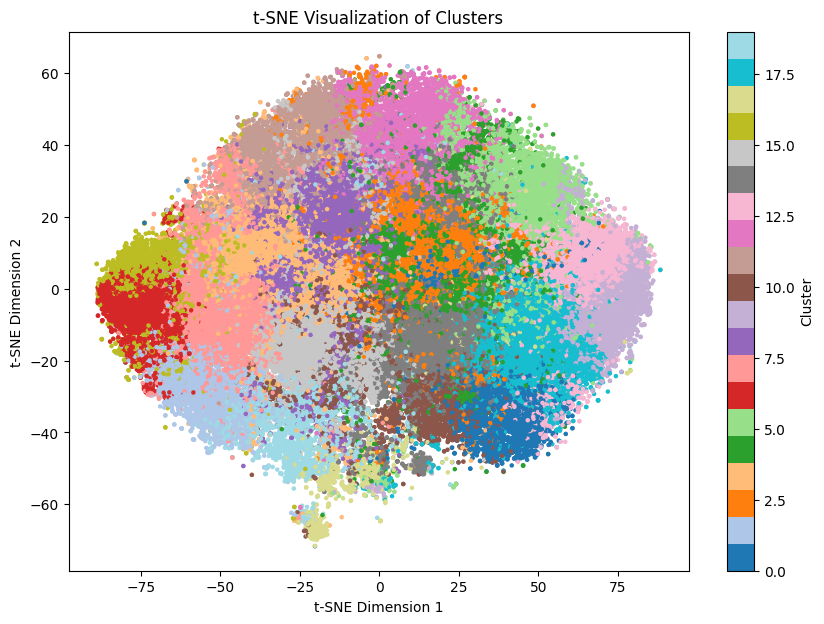

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensionality for visualization using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
latent_2d = tsne.fit_transform(train_normalized_representations)

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=train_cluster_labels, cmap='tab20', s=5)
plt.colorbar(label="Cluster")
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


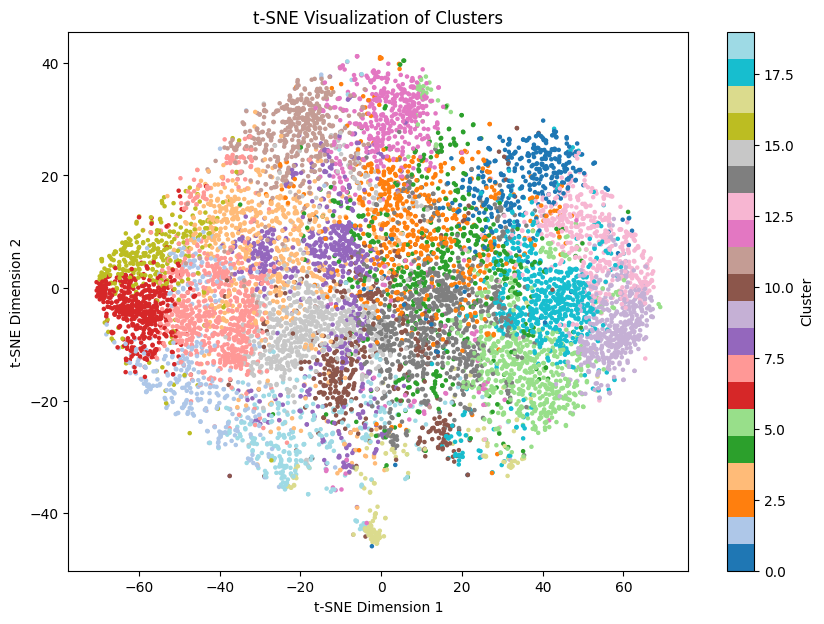

In [ ]:
# Reduce dimensionality for visualization using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
latent_2d = tsne.fit_transform(test_normalized_representations)

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=test_cluster_labels, cmap='tab20', s=5)
plt.colorbar(label="Cluster")
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


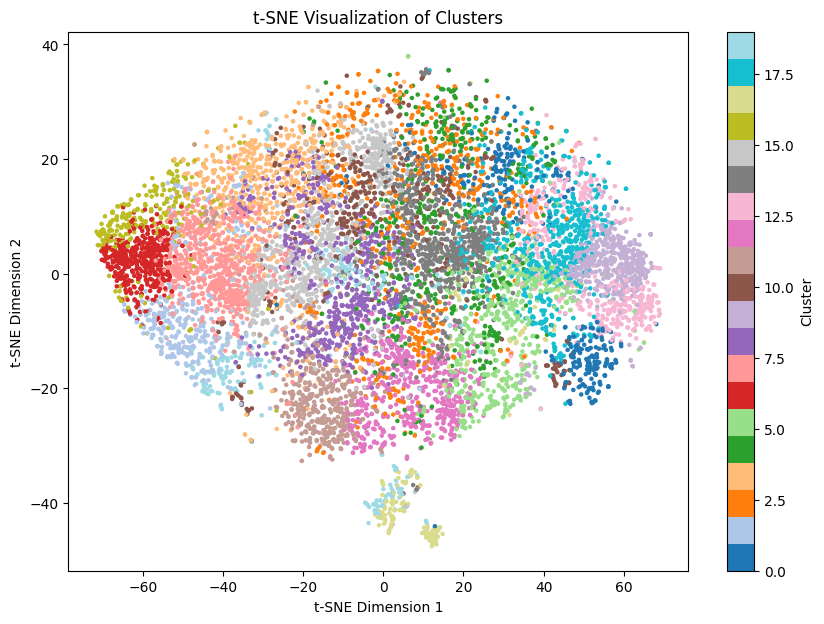

In [ ]:
# Reduce dimensionality for visualization using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
latent_2d = tsne.fit_transform(val_normalized_representations)

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=val_cluster_labels, cmap='tab20', s=5)
plt.colorbar(label="Cluster")
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()